### Import


In [32]:
import numpy as np
import pandas as pd
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
import os
import shutil

### Dataset


In [33]:
class Dataset:
    def __init__(self):
        self.transform = transforms.ToTensor()
        self.trainset = self.load_train_data()
        self.testset = self.load_test_data()

    def load_train_data(self):
        trainset = ds.FashionMNIST(
            root='./data', train=True, download=True, transform=self.transform)
        return trainset

    def load_test_data(self):
        testset = ds.FashionMNIST(
            root='./data', train=False, download=True, transform=self.transform)
        return testset

    def get_train_data(self):
        return self.trainset

    def get_test_data(self):
        return self.testset

    def split_data(self, data, test_size=0.2):

        train_data, val_data = train_test_split(
            data, test_size=test_size, random_state=42)

        return train_data, val_data

    def preprocess_FashionMNIST(self, data):
        processed_data = []

        for i in range(len(data)):
            image, label = data[i]
            image = image.numpy().flatten()
            image = image / 255.0
            if np.isnan(label) == False:
                processed_data.append([image, label])

        processed_data = np.array(processed_data, dtype=object)
        return processed_data
    
    def split_X_y(self, data):
        X = np.array([i[0] for i in data])
        y = np.array([i[1] for i in data])
        return X, y

    def get_data(self):
        train_data = self.preprocess_FashionMNIST(self.trainset)
        test_data = self.preprocess_FashionMNIST(self.testset)

        train_data, val_data = self.split_data(train_data)

        X_train, y_train = self.split_X_y(train_data)
        X_val, y_val = self.split_X_y(val_data)
        X_test, y_test = self.split_X_y(test_data)

        y_train = self.one_hot(y_train)
        y_val = self.one_hot(y_val)
        y_test = self.one_hot(y_test)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # one hot encoding for the labels
    def one_hot(self, y):
        n_values = 10
        y = y.astype(int)
        y = np.eye(n_values)[y.reshape(-1)]
        return y

### Layer


In [34]:
class Layer:
    def forward(self, X):
        raise NotImplementedError("forward not implemented")

    def backward(self, output_grad, learning_rate):
        raise NotImplementedError("backward not implemented")

### Optimizer


In [35]:

class AdamOptimizer:
    def __init__(self,  beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def minimize(self, weights, bias, weights_grad, bias_grad, learning_rate):
        self.t += 1
        combined = np.concatenate(
            [weights_grad.flatten(), bias_grad.flatten()])
        if self.m is None:
            self.m = np.zeros_like(combined)
            self.v = np.zeros_like(combined)

        self.m = self.beta1 * self.m + (1 - self.beta1) * combined
        self.v = self.beta2 * self.v + (1 - self.beta2) * combined**2

        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        combined_update = learning_rate * \
            m_hat / (np.sqrt(v_hat) + self.epsilon)
        weights_update = combined_update[:weights.size].reshape(weights.shape)
        bias_update = combined_update[weights.size:]

        weights = weights - weights_update
        bias = bias - bias_update

        return weights, bias

### Dense Layer


In [36]:

def xavier_init(input_size, output_size, mode='uniform'):
    if mode == 'normal':
        stddev = np.sqrt(2 / (input_size + output_size))
        return np.random.normal(0, stddev, (input_size, output_size))
    
    elif mode == 'uniform':
        limit = np.sqrt(6 / (input_size + output_size))
        return np.random.uniform(-limit, limit, (input_size, output_size))


class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = xavier_init(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, X):
        self.input = X
        self.output = np.dot(X, self.weights) + self.bias
        return self.output

    def backward(self, output_grad, learning_rate):
        # input_grad = np.dot(output_grad, self.weights.T)
        input_grad = np.matmul(output_grad, self.weights.T)
        # weights_grad = np.dot(self.input.T, output_grad)
        weights_grad = np.matmul(self.input.T, output_grad)
        bias_grad = np.sum(output_grad, axis=0, keepdims=True)

        self.weights, self.bias = self.optimizer.minimize(
            self.weights, self.bias, weights_grad, bias_grad, learning_rate)
        return input_grad
    
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

### ReLU Layer


In [37]:
class ReLULayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, output_grad, learning_rate):
        return output_grad * np.maximum(0, np.sign(self.input))


### Softmax Layer


In [38]:
class SoftmaxLayer(Layer):

    def forward(self, X):
        self.input = X
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, output_grad, learning_rate, loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            input_grad = output_grad
        else:
            # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
            input_grad = np.zeros_like(output_grad)
            for i in range(output_grad.shape[0]):
                jacobian = - \
                    np.outer(self.output[i], self.output[i]
                             ) + np.diag(self.output[i])
                input_grad[i] = np.dot(output_grad[i], jacobian)

        return input_grad

### Dropout Layer


In [39]:
class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
        self.mask = None

    def forward(self, X, training=True):
        self.input = X

        if training == False or self.p == 0:
            self.output = X
            return self.output

        if self.p == 1:
            self.output = np.zeros(X.shape)
            return self.output

        # self.mask = np.random.binomial(1, self.p, size=X.shape) / self.p
        # self.output = X * self.mask
        self.mask = (np.random.rand(X.shape[0], X.shape[1]) >= self.p).astype(float) / (1 - self.p)
        self.output = X * self.mask
        return self.output

    def backward(self, output_grad, learning_rate, training=True):
        if training == False or self.p == 0:
            return output_grad
        return output_grad * self.mask

### Batch Normalization Layer


In [40]:


class BatchNormLayer(Layer):
    def __init__(self, input_size, epsilon=1e-8, momentum=0.9):
        self.input_size = input_size
        self.epsilon = epsilon
        self.momentum = momentum 

        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))

        self.running_mean = np.zeros((1, input_size))
        self.running_var = np.ones((1, input_size))

        self.input = None
        self.normalized_input = None
        self.batch_mean = None
        self.batch_var = None

        self.optimizer = AdamOptimizer()

    def forward(self, X, training=True):

        self.input = X

        if training:
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)

            self.normalized_input = (
                X - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)

            self.running_mean = self.momentum * self.running_mean + \
                (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + \
                (1 - self.momentum) * self.batch_var
        else:
            self.normalized_input = (
                X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        output = self.gamma * self.normalized_input + self.beta
        return output

    def backward(self, output_grad, learning_rate):

        m = self.input.shape[0] 
        gamma_grad = np.sum(
            output_grad * self.normalized_input, axis=0, keepdims=True)
        beta_grad = np.sum(output_grad, axis=0, keepdims=True)

        normalized_grad = output_grad * self.gamma
        inv_var = 1 / np.sqrt(self.batch_var + self.epsilon)
        var_grad = np.sum(normalized_grad * (self.input - self.batch_mean) * -
                          0.5 * inv_var**3, axis=0, keepdims=True)
        mean_grad = np.sum(normalized_grad * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0,
                           keepdims=True) + var_grad * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)

        input_grad = normalized_grad / np.sqrt(self.batch_var + self.epsilon) + var_grad * 2 * (
            self.input - self.batch_mean) / m + mean_grad / m

        self.gamma, self.beta = self.optimizer.minimize(
            self.gamma, self.beta, gamma_grad, beta_grad, learning_rate)

        return input_grad

### Cross Entropy Loss


In [41]:

class CrossEntropyLoss:
    def __init__(self):
        self.epsilon = 1e-15

    def loss(self, y_true, output):
        output = np.clip(output, self.epsilon, 1 - self.epsilon)
        loss = np.mean(-np.sum(y_true * np.log(output), axis=1))
        return loss

    def loss_prime(self, y_true, output):
        return (output - y_true) / y_true.shape[0]

### Neural Network


In [42]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    def forward_propagation(self, X, training=True):

        output = X
        for layer in self.layers:
            if isinstance(layer, DropoutLayer) or isinstance(layer, BatchNormLayer):
                output = layer.forward(output, training=training)
            else:
                output = layer.forward(output)
        return output

    def backward_propagation(self, output_grad, learning_rate):

        grad = output_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

    def fit(self, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.001, batch_size=32, shuffle=False):

        num_samples = X_train.shape[0]

        training_losses = []
        validation_losses = []
        training_accuracies = []
        validation_accuracies = []
        training_f1_scores = []
        validation_f1_scores = []

        for epoch in range(epochs):
            error = 0

            with tqdm(total=(num_samples // batch_size), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
                for i in range(0, num_samples, batch_size):
                    X_batch = X_train[i:i + batch_size]
                    y_batch = y_train[i:i + batch_size]

                    if shuffle:
                        idx = np.random.permutation(len(X_batch))
                        X_batch = X_batch[idx]
                        y_batch = y_batch[idx]

                    output = self.forward_propagation(X_batch)
                    loss = self.loss_fn.loss(y_batch, output)
                    error += loss

                    grad = self.loss_fn.loss_prime(y_batch, output)
                    self.backward_propagation(grad, learning_rate)

                    pbar.update(1)

            training_loss = error / (num_samples // batch_size)
            training_losses.append(training_loss)

            y_pred = self.predict(X_train)
            y_true = np.argmax(y_train, axis=1)
            training_accuracy = accuracy_score(y_true, y_pred)
            training_accuracies.append(training_accuracy)
            training_f1 = f1_score(y_true, y_pred, average='macro')
            training_f1_scores.append(training_f1)

            val_output = self.forward_propagation(X_val, training=False)
            validation_loss = self.loss_fn.loss(y_val, val_output)
            validation_losses.append(validation_loss)

            y_pred = self.predict(X_val)
            y_true = np.argmax(y_val, axis=1)
            validation_accuracy = accuracy_score(y_true, y_pred)
            validation_accuracies.append(validation_accuracy)
            validation_f1 = f1_score(y_true, y_pred, average='macro')
            validation_f1_scores.append(validation_f1)

            print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {training_loss:.4f} - Validation Loss: {validation_loss:.4f} - Training Accuracy: {training_accuracy:.4f} - Validation Accuracy: {validation_accuracy:.4f} - Training F1: {training_f1:.4f} - Validation F1: {validation_f1:.4f}')

        return training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores

    def predict(self, X):
        output = self.forward_propagation(X, training=False)
        return np.argmax(output, axis=1)
    
    def performance_metrics(self, X, y):
        y_pred = self.predict(X)
        y_true = np.argmax(y, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)
        return accuracy, f1, cm
    
    def compile(self, optimizer=AdamOptimizer(), loss_fn=CrossEntropyLoss()):
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.set_optimizer(deepcopy(optimizer))

        self.loss_fn = loss_fn

    def save_weights(self, filename):
        weights = []
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                weights.append((layer.weights, layer.bias))
            elif isinstance(layer, BatchNormLayer):
                weights.append((layer.gamma, layer.beta, layer.running_mean, layer.running_var))
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)


    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)

        weight_index = 0
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights, layer.bias = weights[weight_index]
                weight_index += 1
            elif isinstance(layer, BatchNormLayer):
                layer.gamma, layer.beta, layer.running_mean, layer.running_var = weights[weight_index]
                weight_index += 1

    def summary(self):
        for i, layer in enumerate(self.layers):
            print(f'Layer {i + 1}: {layer.__class__.__name__}')
            if isinstance(layer, DenseLayer):
                print(f'Input Size: {layer.input_size} - Output Size: {layer.output_size}')
            if isinstance(layer, DropoutLayer):
                print(f'Dropout Rate: {layer.p}')
            if isinstance(layer, BatchNormLayer):
                print(f'Input Size: {layer.input_size} - Epsilon: {layer.epsilon} - Momentum: {layer.momentum}')
            print('\n')


### Plot Performance Metrics


In [43]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, model_name):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.suptitle(model_name)
    plt.savefig(f'plots/{model_name}.png')

    #plt.show()


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('plots/' + model_name + '_cm.png')
    #plt.show()

def clean_file_dir():
    open('report.txt', 'w').close()
    shutil.rmtree('model_weights')
    os.makedirs('model_weights')
    shutil.rmtree('plots')
    os.makedirs('plots')

### Main

In [44]:
def report_models(layers, learning_rates, X_train, y_train, X_val, y_val):
    for i in range(len(layers)):
        for j in range(len(learning_rates)):
            model = NeuralNetwork(layers[i])
            model.compile()
          
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores = model.fit(
                X_train, y_train, X_val, y_val, epochs=25, learning_rate=learning_rates[j], batch_size=32)
            
            plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores, f'Model {i} - Learning Rate {learning_rates[j]}')
            
            with open('report.txt', 'a') as f:
                f.write(f'Model {i} - Learning Rate {learning_rates[j]}\n')
                f.write(f'Training Loss: {training_losses[-1]}\n')
                f.write(f'Validation Loss: {validation_losses[-1]}\n')
                f.write(f'Training Accuracy: {training_accuracies[-1]}\n')
                f.write(f'Validation Accuracy: {validation_accuracies[-1]}\n')
                f.write(f'Training F1: {training_f1_scores[-1]}\n')
                f.write(f'Validation F1: {validation_f1_scores[-1]}\n\n')
           

            # with open(f'model/model_{i}_{j}.pkl', 'wb') as f:
            #     pickle.dump(model, f)

            model.save_weights(f'model_weights/model_{i}_{j}_weights.pkl')

In [45]:
def generate_cm_for_all_models(layers, learning_rates, X_test, y_test):
    for i in range(len(layers)):
        for j in range(len(learning_rates)):
            model = NeuralNetwork(layers[i])
            model.load_weights(f'model_weights/model_{i}_{j}_weights.pkl')
            cm = model.performance_metrics(X_test, y_test)[2]
            plot_confusion_matrix(cm, f'Model {i} - Learning Rate {learning_rates[j]}')

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)
(10000, 784) (10000, 10)


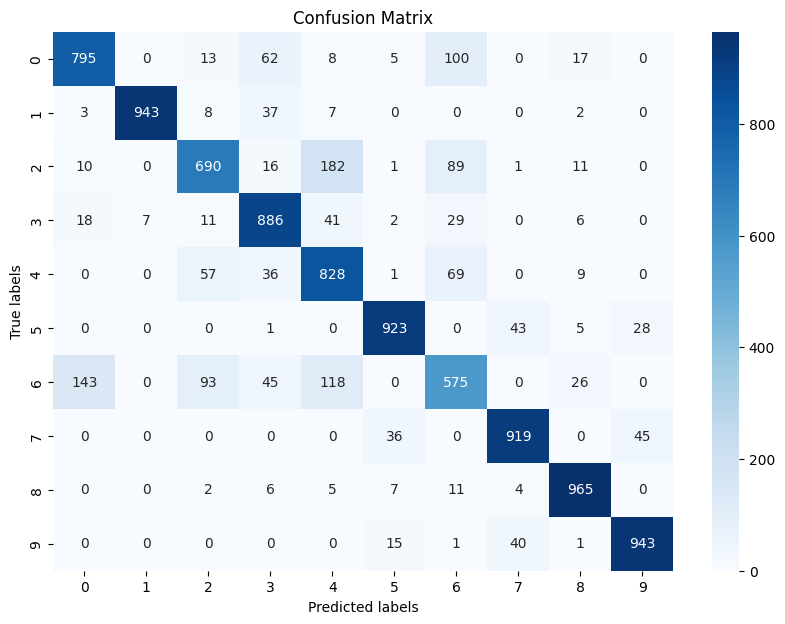

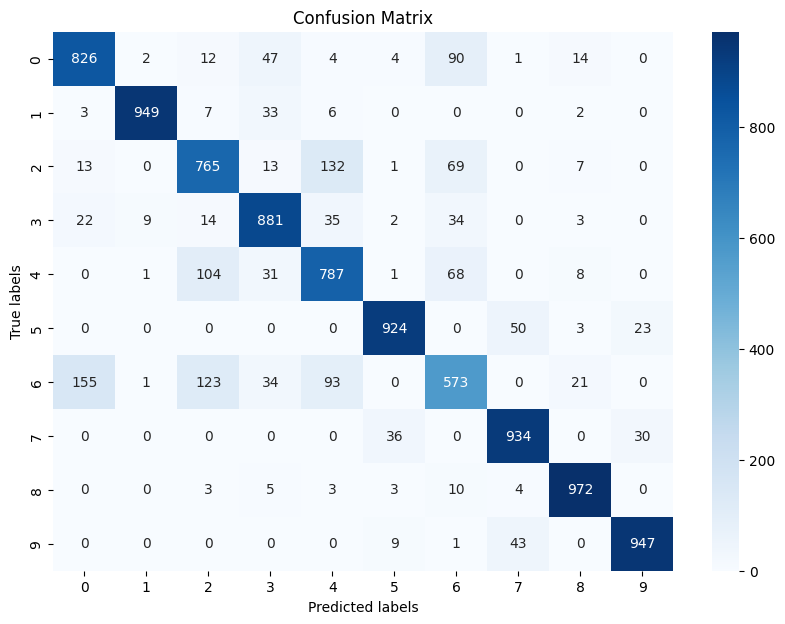

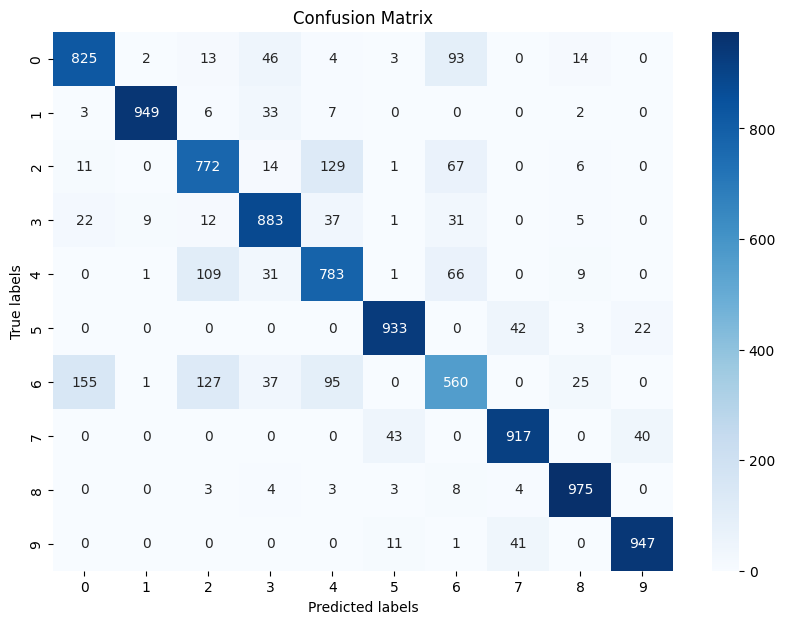

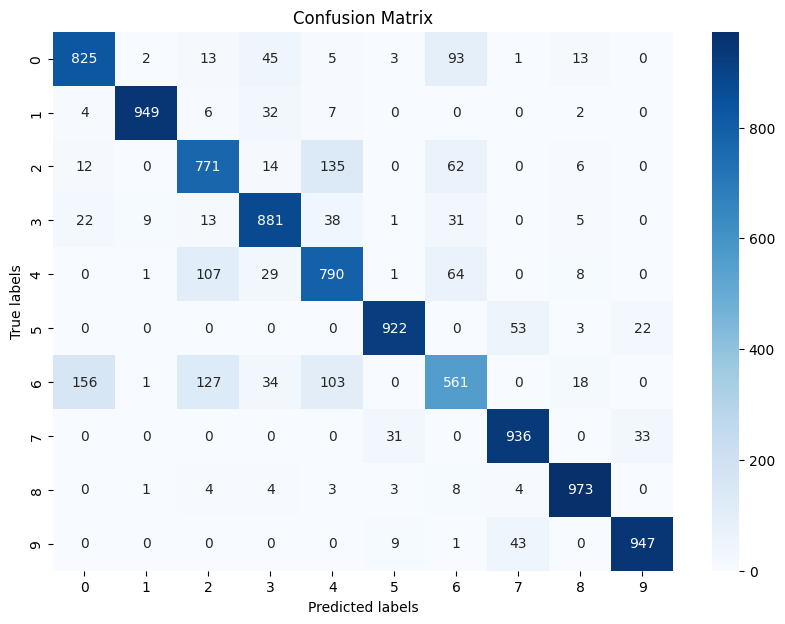

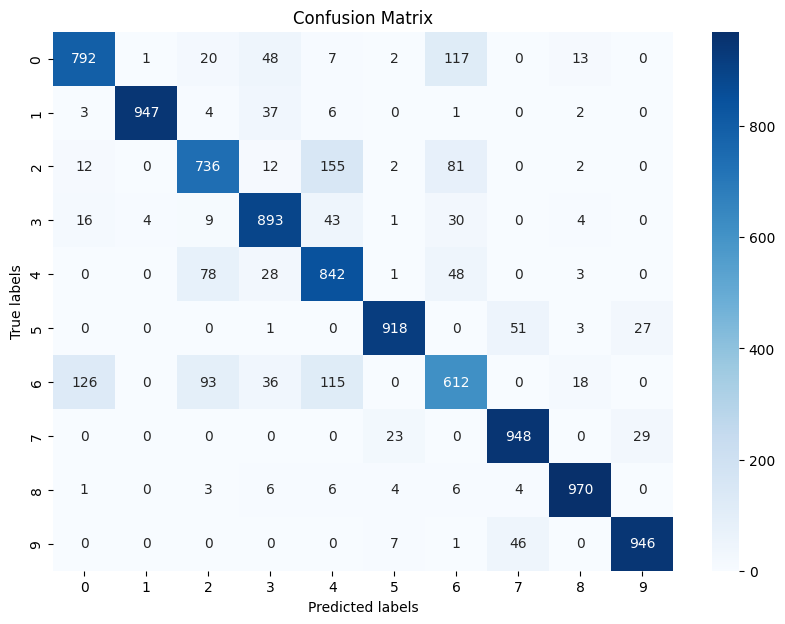

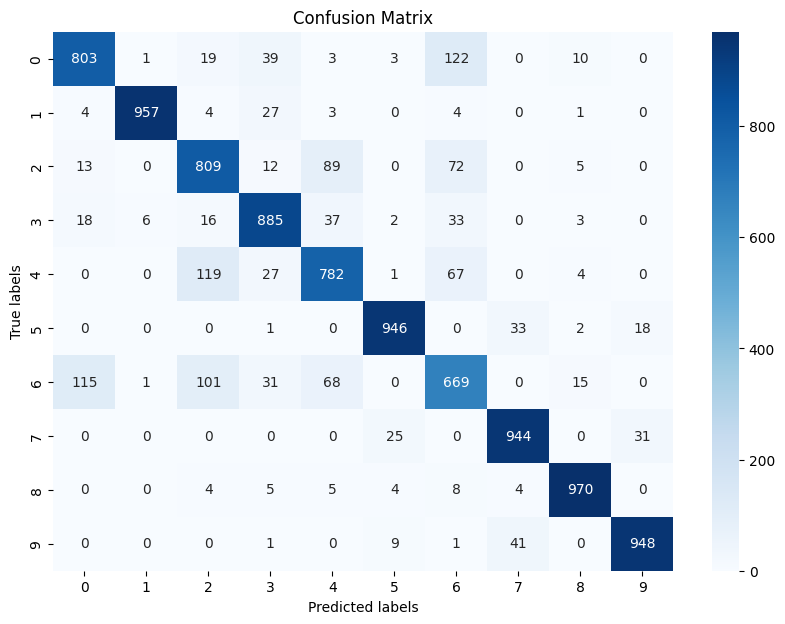

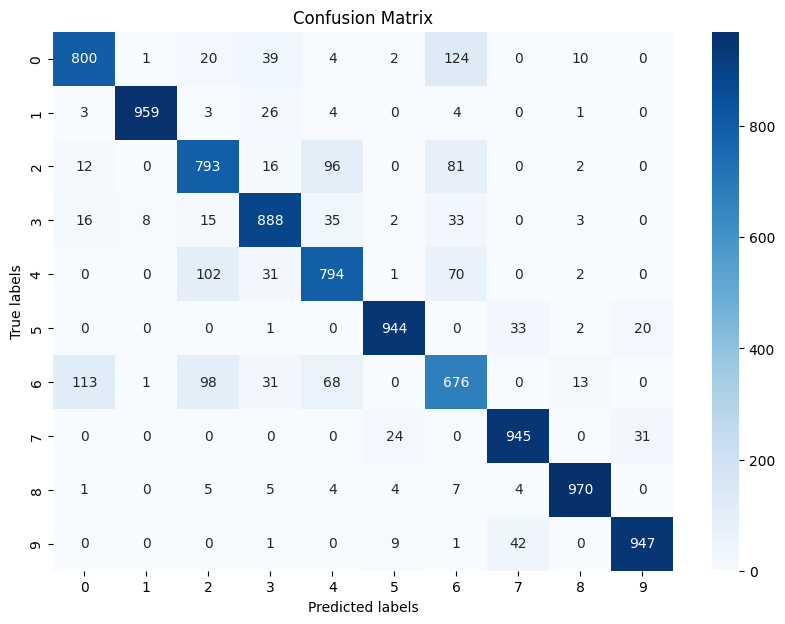

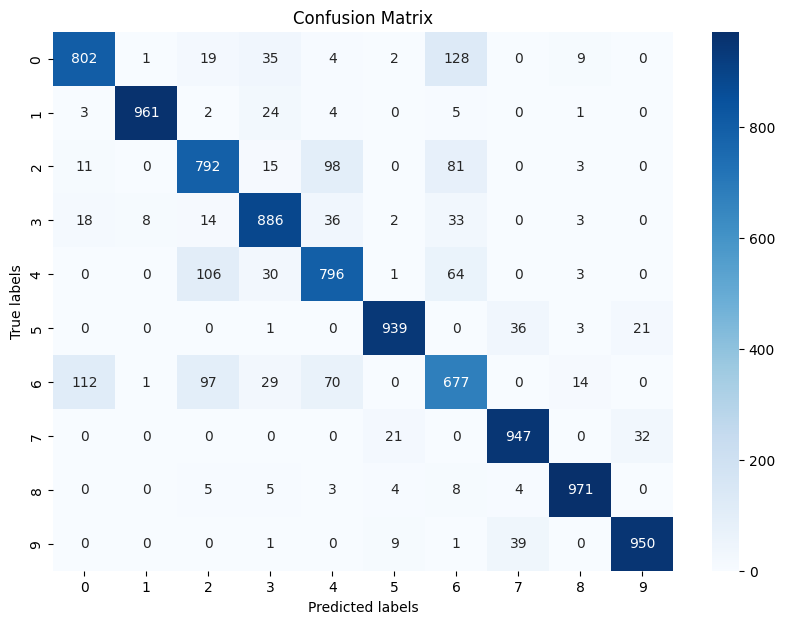

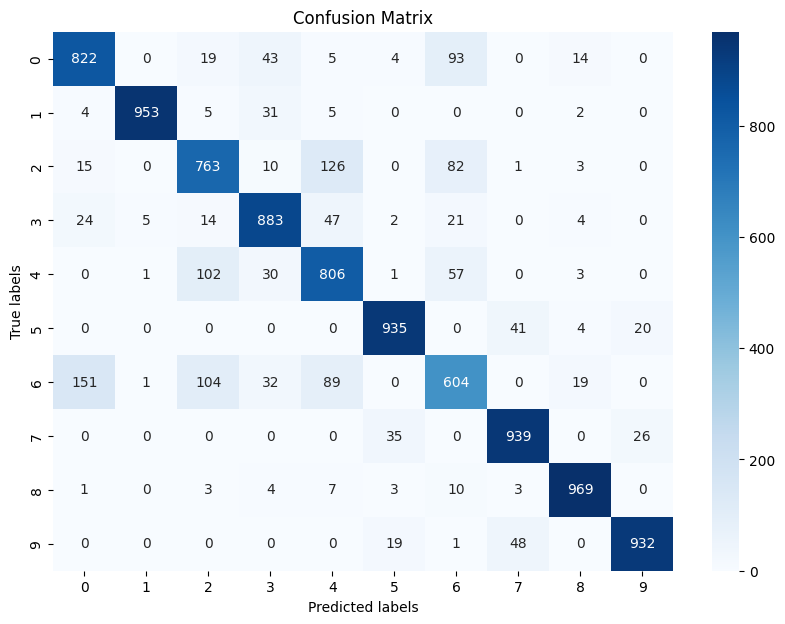

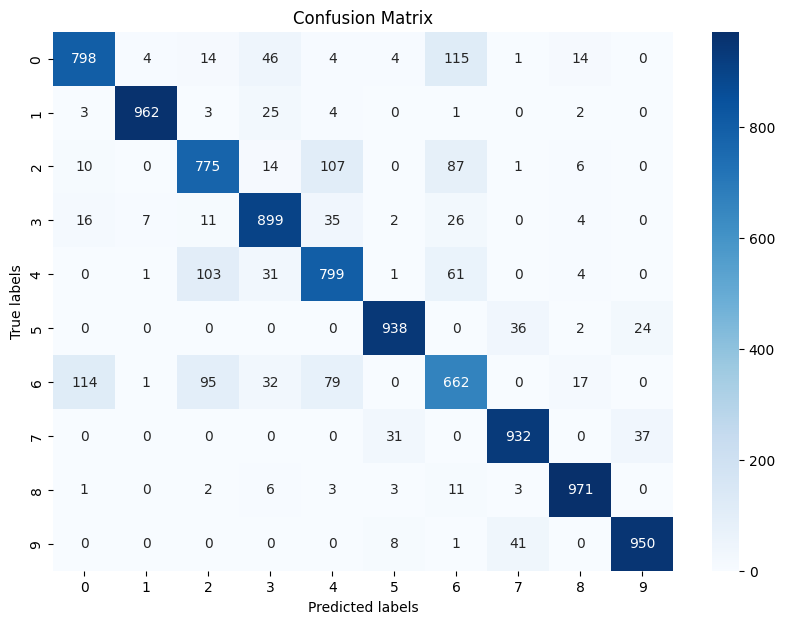

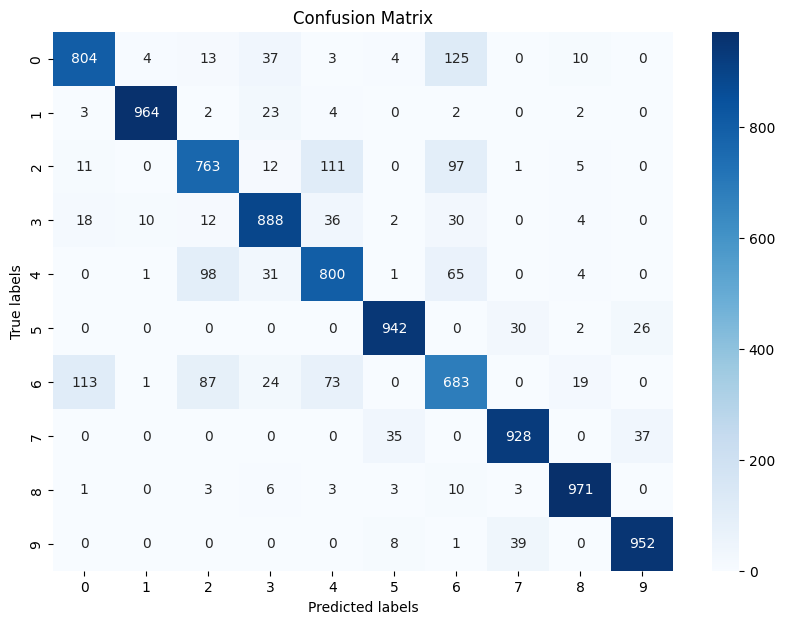

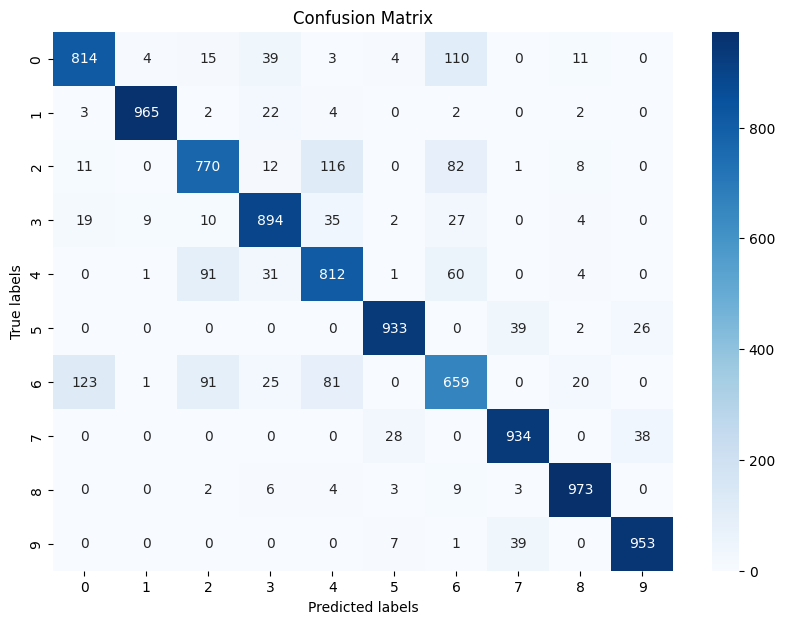

In [46]:

ds = Dataset()
X_train, y_train, X_val, y_val, X_test, y_test = ds.get_data()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

layers =[[
    DenseLayer(784, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 128),
    ReLULayer(),
    BatchNormLayer(128),
    DropoutLayer(0.5),
    DenseLayer(128, 64),
    ReLULayer(),
    BatchNormLayer(64),
    DropoutLayer(0.5),
    DenseLayer(64, 10),
    SoftmaxLayer()
], [
    DenseLayer(784, 512),
    ReLULayer(),
    BatchNormLayer(512),
    DropoutLayer(0.5),
    DenseLayer(512, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 10),
    SoftmaxLayer()
], [
    DenseLayer(784, 512),
    ReLULayer(),
    BatchNormLayer(512),
    DropoutLayer(0.5),
    DenseLayer(512, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 128),
    ReLULayer(),
    BatchNormLayer(128),
    DropoutLayer(0.5),
    DenseLayer(128, 10),
    SoftmaxLayer()
]
]

learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]

# nn = NeuralNetwork(layers[1])
# nn.compile()
# train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = nn.fit(
#     X_train, y_train, X_val, y_val, epochs=5, learning_rate=0.001, batch_size=32)
# plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, 'Neural Network')
# nn.save_weights('nn_model_weights.pkl')

# test_accuracy, test_f1, cm = nn.performance_metrics(X_test, y_test)

# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test F1: {test_f1:.4f}')

# plot_confusion_matrix(cm)

# with open('nn_model.pkl', 'wb') as f:
#     pickle.dump(nn, f)

#print(len(layers))

# clean_file_dir()

# report_models(layers, learning_rates, X_train, y_train, X_val, y_val)
generate_cm_for_all_models(layers, learning_rates, X_test, y_test)


In [47]:
# save the model weights

nn2 = NeuralNetwork(layers[1])
nn2.load_weights('model_weights/model_1_1_weights.pkl')

test_accuracy, test_f1, cm = nn2.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

Test Accuracy: 0.8713
Test F1: 0.8713


In [48]:
nn3 = NeuralNetwork(layers[2])
nn3.load_weights('model_weights/model_2_1_weights.pkl')

test_accuracy, test_f1, cm = nn3.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

Test Accuracy: 0.8686
Test F1: 0.8682


In [49]:
nn4 = NeuralNetwork(layers[0])
nn4.load_weights('model_weights/model_0_1_weights.pkl') 

test_accuracy, test_f1, cm = nn4.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

Test Accuracy: 0.8558
Test F1: 0.8545
